In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import datetime
from dateutil.parser import parse
from utils import mean_2d_diff_size

Read the logs of our implementation

In [2]:
LOGS_PATH = "../mil-2/logs/"
objs_in_path = listdir(LOGS_PATH)
data_paths = [join(LOGS_PATH, f) for f in objs_in_path if isfile(join(LOGS_PATH, f)) and 'json' in f]

In [3]:
logs = []
for path in data_paths:
    with open(path) as f:
        d = json.load(f)
    logs.append(json_normalize(d))
data = pd.concat(logs, axis=0, ignore_index=True)
for field in ['end_time', 'start-time', 'start-compute-time', 'end-compute-time']:
    data[field] = data[field].apply(parse)
data['compute-time'] = (data['end-compute-time'] - data['start-compute-time'])/np.timedelta64(1, 's')

In [4]:
LOGS_PATH = "../mil-2/logs-no-stopping/"
objs_in_path = listdir(LOGS_PATH)
data_paths = [join(LOGS_PATH, f) for f in objs_in_path if isfile(join(LOGS_PATH, f)) and 'json' in f]

In [5]:
logs = []
for path in data_paths:
    with open(path) as f:
        d = json.load(f)
    logs.append(json_normalize(d))
data_no_stopping = pd.concat(logs, axis=0, ignore_index=True)
for field in ['end_time', 'start-time', 'start-compute-time', 'end-compute-time']:
    data_no_stopping[field] = data_no_stopping[field].apply(parse)
data_no_stopping['compute-time'] = (data_no_stopping['end-compute-time'] - data_no_stopping['start-compute-time'])/np.timedelta64(1, 's')

Plot the running time vs number of workers for each implementation (i.e. asynchronous with and without lock)

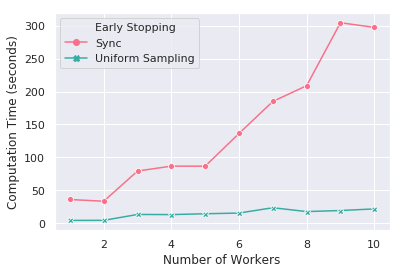

In [7]:
early_stopping_df = data[['num_workers', 'compute-time']].groupby(['num_workers']).median().reset_index()
early_stopping_df['early_stopping'] = 'Sync'

no_early_stopping_df = data_no_stopping[['num_workers', 'compute-time']].groupby(['num_workers']).median().reset_index()
no_early_stopping_df['early_stopping'] = 'Uniform Sampling'

data_df = pd.concat([early_stopping_df, no_early_stopping_df], sort=False)
data_df['num_workers'] = pd.to_numeric(data_df['num_workers'])

ax = sns.lineplot(x='num_workers', y='compute-time', hue='early_stopping', style='early_stopping', markers=True, dashes=False, palette=sns.color_palette("husl", 2), data=data_df)
ax.set_xlabel('Number of Workers')
ax.set_ylabel('Computation Time (seconds)')
legend = ax.legend()
legend.texts[0].set_text('Early Stopping');